# Variational Autoencoder for fashion MNIST

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

## Parameters

In [3]:
IMAGE_SIZE = 32
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 50
BETA = 500

## Dataset Preparation and visualization 

In [4]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [5]:
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

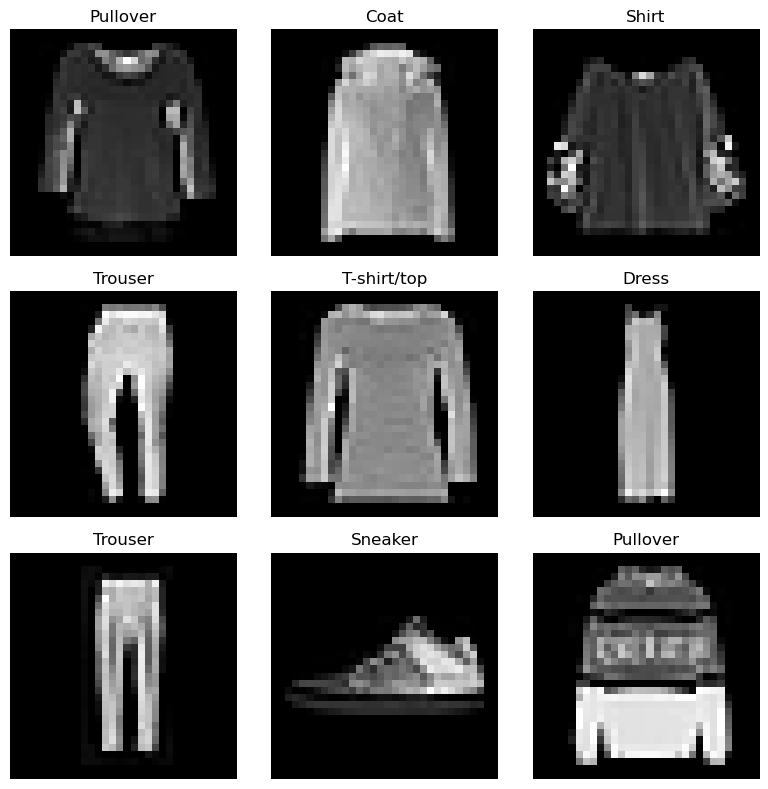

In [6]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.ravel()

for i in range(9):
    index = np.random.randint(0, len(x_train))  
    axes[i].imshow(x_train[index], cmap='gray')  
    axes[i].set_title(class_names[y_train[index]]) 
    axes[i].axis('off') 

plt.tight_layout()
plt.show()

## Variational Autoencoder Architecture

In [7]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 4, 4, 128)    73856       ['conv2d_1[0][0]']               
                                                                                            

In [9]:
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       18464 

In [10]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [11]:
vae = VAE(encoder, decoder)

In [12]:
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

## Training

In [13]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="D:\\Gen ai\\Lab\\VAE",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [14]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/50
938/938 [==============================] - 12s 11ms/step - total_loss: 152.0638 - reconstruction_loss: 147.5322 - kl_loss: 4.5315 - val_loss: 130.7601 - val_reconstruction_loss: 125.8208 - val_kl_loss: 4.9393
Epoch 2/50
938/938 [==============================] - 10s 11ms/step - total_loss: 134.9914 - reconstruction_loss: 130.0294 - kl_loss: 4.9620 - val_loss: 128.2309 - val_reconstruction_loss: 122.9354 - val_kl_loss: 5.2955
Epoch 3/50
938/938 [==============================] - 10s 11ms/step - total_loss: 133.5233 - reconstruction_loss: 128.4689 - kl_loss: 5.0542 - val_loss: 126.6937 - val_reconstruction_loss: 121.5539 - val_kl_loss: 5.1398
Epoch 4/50
938/938 [==============================] - 10s 11ms/step - total_loss: 132.7076 - reconstruction_loss: 127.5971 - kl_loss: 5.1106 - val_loss: 127.3383 - val_reconstruction_loss: 121.8846 - val_kl_loss: 5.4537
Epoch 5/50
938/938 [==============================] - 10s 11ms/step - total_loss: 132.2150 - reconstruction_loss: 127.05

In [15]:
vae.save_weights("D:/Gen ai/Lab/VAE/models/vae.keras")
encoder.save("D:/Gen ai/Lab/VAE/models/encoder.keras")
decoder.save("D:/Gen ai/Lab/VAE/models/decoder.keras")

## Reconstruction

In [16]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [17]:
z_mean, z_log_var, reconstructions = vae.predict(example_images)

157/157 [==============================] - 1s 4ms/step


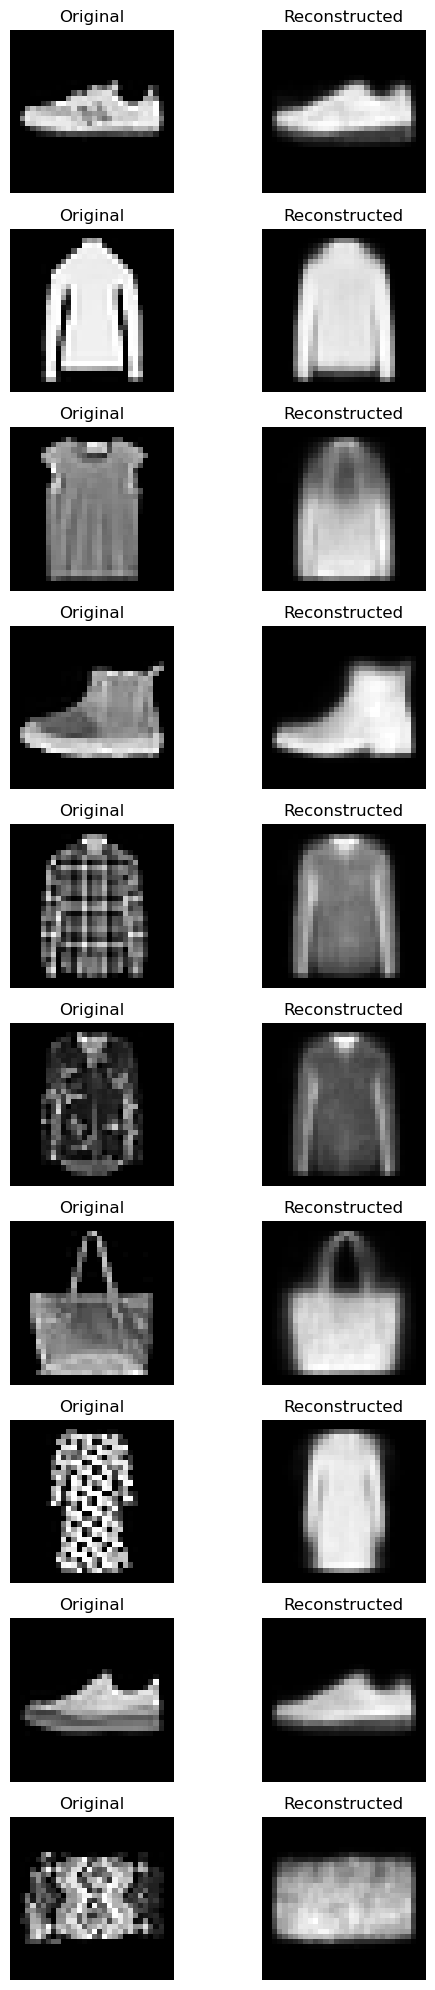

In [18]:
n_samples = 10 
fig, axes = plt.subplots(n_samples, 2, figsize=(6, 2 * n_samples))

for i in range(n_samples):
    index = np.random.randint(0, n_to_predict)  
    
    axes[i, 0].imshow(example_images[index], cmap='gray')
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(reconstructions[index], cmap='gray')
    axes[i, 1].set_title("Reconstructed")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [19]:
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 0s 2ms/step


In [20]:
print(z[:10])

[[-3.2205608e-01  1.0365772e+00]
 [ 6.9323766e-01 -1.8844686e-01]
 [ 2.9503703e-03 -2.1350780e+00]
 [-8.4849012e-01 -1.7140145e+00]
 [ 1.3596062e-01  4.6424679e-02]
 [ 1.3639849e+00 -2.7636240e+00]
 [-1.1447341e+00 -7.0654936e-02]
 [-1.7085949e-01 -6.9396265e-02]
 [-6.4839125e-01  3.6217520e+00]
 [-2.9439682e-01  2.3147635e+00]]


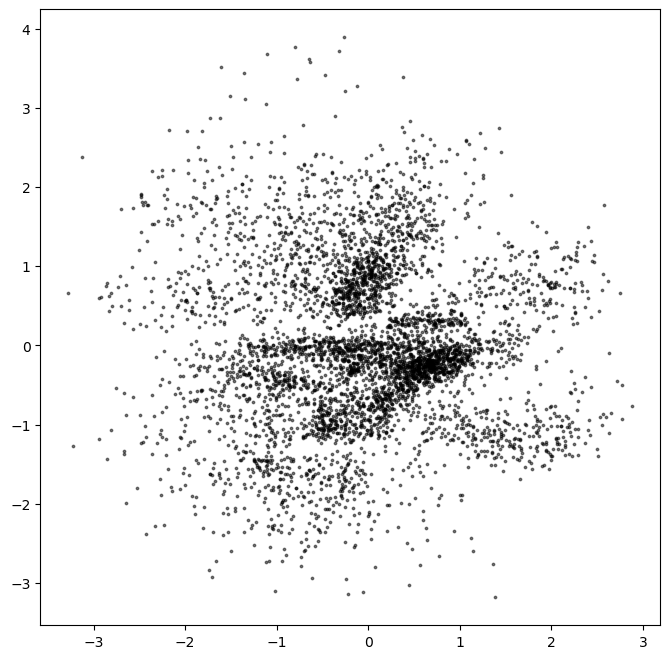

In [21]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [22]:
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [23]:
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 276ms/step


In [24]:
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

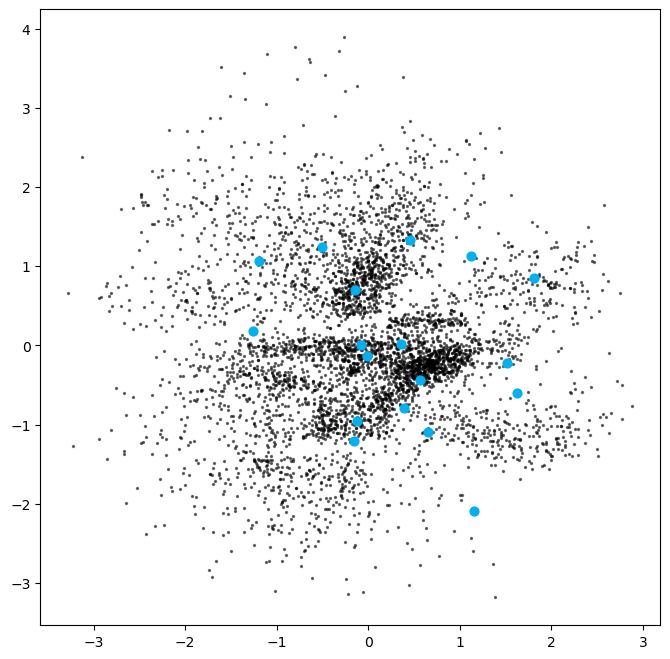

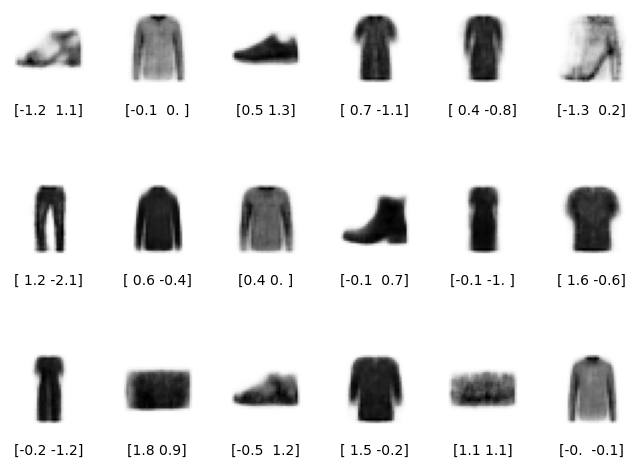

In [25]:
figsize = 8
plt.figure(figsize=(figsize, figsize))

plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

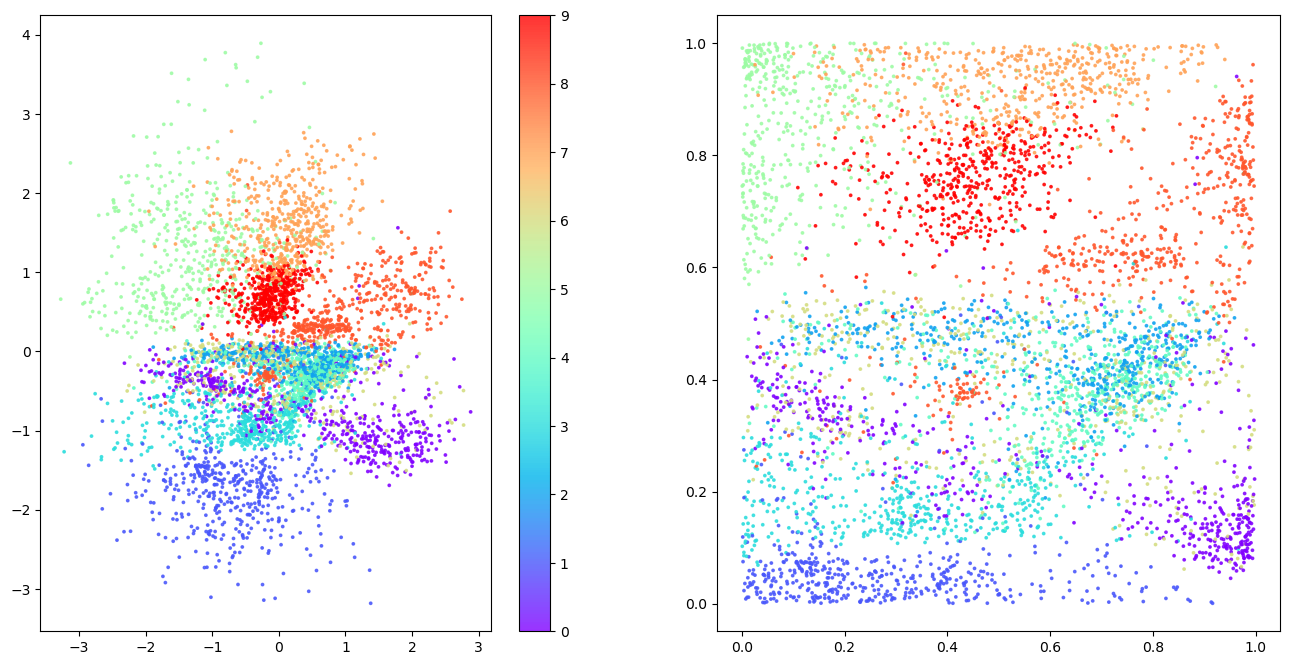

In [26]:
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()